# 재분류 데이터를 활용한 머신러닝 재실험 
- 실험 데이터는 A군과 B군으로 나누어 평가한다.
- A군: 편차 항목만 사용, B군: 모든 항목(편차, 하한공차, 상한공차, 기준값, 측정값)을 사용

| Comparison Group | Content | Form |
|------------------|---------|------|
| A군(편차 특성만 사용) | Content 1| Form 1|
| B군(모든 특성을 사용)      | Content 2| Form 2|
| A, B 중 결과 더 좋은 것에 대해 축소한 차원으로 다시 실험      | Content 2| Form 2|


1. Random Forest
2. Logistic Regression
3. K-Nearest Nighbor(KNN)
4. Support Vector Machine(SVM)
5. Gradient Descent
6. XGBoost

In [224]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score, roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.tree import plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib import rc
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.font_manager as fm
import warnings
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from scipy import stats
import xgboost as xgb
from scipy.stats import probplot, kstest, anderson, norm

# 경고 메시지 무시
warnings.filterwarnings("ignore", category=UserWarning, module='IPython.core.pylabtools')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows의 경우

# A군: 편차 항목만 사용해서 모델 학습 및 평가
one_feature = pd.read_csv('./data/cmm_deviation_re.csv', skiprows=0, encoding='utf-8')

# B군: 모든 항목(편차, 하한공차, 상한공차, 기준값, 측정값)을 사용해서 모델 학습 및 평가
all_feature = pd.read_csv('./data/cmm_all_re.csv', skiprows=0, encoding='utf-8')

In [225]:
all_feature.columns

Index(['파일명', '평면1_평면도_측정값', '원1(I) <상>_D_측정값', '원2(I) <중>_D_측정값',
       '원3(I) <하>_D_측정값', '원통1(I) <- 원1, 원2, 원3의 측정점 병합_D_측정값',
       '원통1(I) <- 원1, 원2, 원3의 측정점 병합_원통도_측정값',
       '원통1(I) <- 원1, 원2, 원3의 측정점 병합_직각도_측정값',
       '점2 <- 점1의 되부름 <열전 관리치수(Spec : 116.6±0.1)>_X_측정값',
       '점2 <- 점1의 되부름 <열전 관리치수(Spec : 116.6±0.1)>_Y_측정값',
       ...
       '점28 <- 점27의 되부름 <소재 원점>_Y_편차', '각도2 <- 각도[XYPLAN]:직선23와 직선24_Ang_편차',
       '점29 <- 점13의 되부름 <소재원점>_X_편차', '점29 <- 점13의 되부름 <소재원점>_Y_편차',
       '점30 <- 점18의 되부름 <소재원점>_X_편차', '점30 <- 점18의 되부름 <소재원점>_Y_편차',
       '직선25 <- 직선18의 되부름_X/Y_편차', '직선26 <- 직선16의 되부름_X/Y_편차',
       '거리4 <- XAXIS[평균]:점32와 점31 <소재기준>_DS_편차', '품질상태'],
      dtype='object', length=327)

## 데이터 전처리
- 데이터의 차원 축소: 데이터의 분산을 최대화하는 새로운 축(주성분)을 4개 생성
- 데이터의 분포 시각화: 데이터의 분포가 정규분포인지 분산이 큰지 파악 => 정규분포 => 표준화로 정규화함. 
- 정규화: 데이터의 분포에 따른 적절한 정규화방법 선택 => 표준화
- train/test data 분리

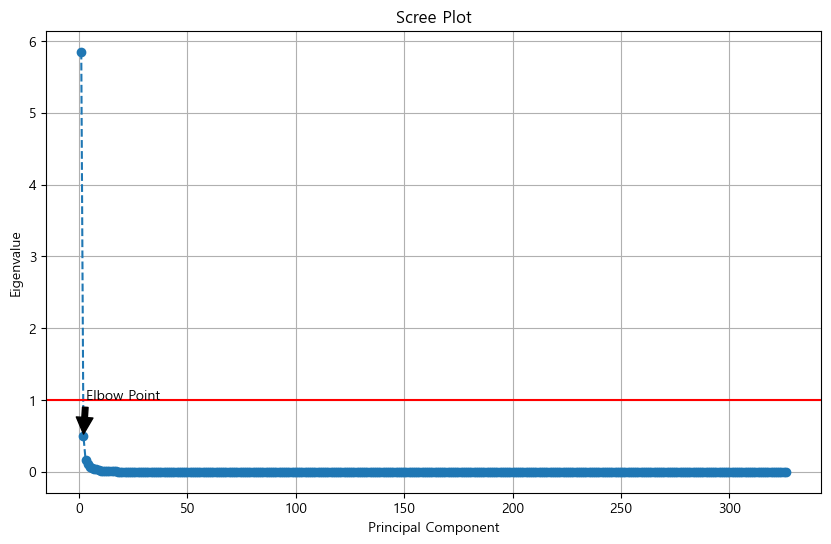

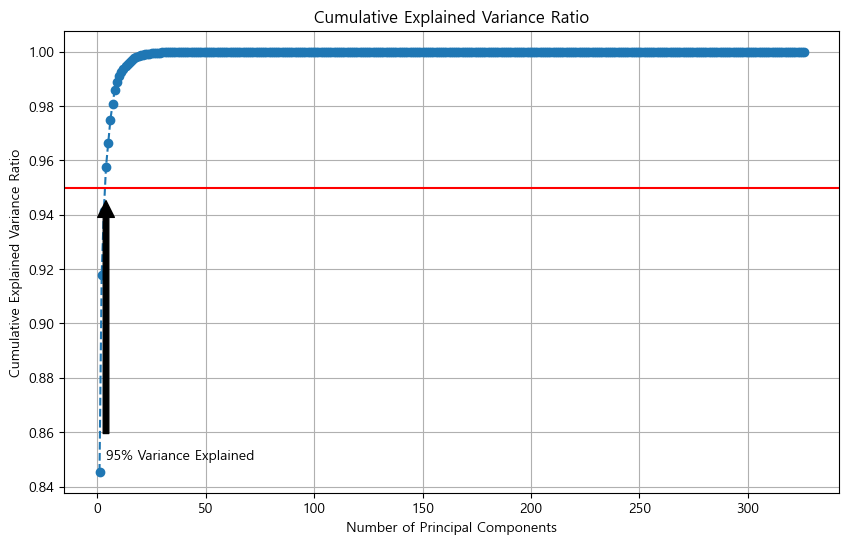

In [226]:
ex=all_feature
del ex['파일명']

# PCA 수행
data=ex
pca = PCA()
pca.fit(data)

# 설명된 분산 비율 및 고유값 계산
explained_variance_ratio = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

# Scree Plot 생성
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='-')
plt.annotate('Elbow Point', xy=(2, eigenvalues[1]), xytext=(3, eigenvalues[1] + 0.5),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.grid(True)
plt.show()

# 누적 설명된 분산 비율 그래프 생성
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.annotate('95% Variance Explained', xy=(np.argmax(cumulative_variance_ratio >= 0.95) + 1, 0.95), 
             xytext=(np.argmax(cumulative_variance_ratio >= 0.95) + 1, 0.85),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.grid(True)
plt.show()

In [227]:
# PCA 수행
pca = PCA()
pca.fit(ex)

# 설명된 분산 비율 확인
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# 설명된 분산 비율 95%에 도달하는 주성분 수 찾기
n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1

# 선택된 n_components로 PCA 재수행
pca = PCA(n_components=n_components)
reduced_data = pca.fit_transform(ex)
print(f'선택된 주성분 수: {n_components}')
# PCA 결과를 DataFrame으로 변환
pca_df = pd.DataFrame(data=reduced_data, columns=['principal component 1', 'principal component 2','principal component 3','principal component 4'])
pca_df

선택된 주성분 수: 4


,principal component 1,principal component 2,principal component 3,principal component 4
0,-0.033297,0.236676,-0.871714,0.285621
1,0.149635,-0.404631,-0.490574,0.442295
2,0.091701,-0.748988,-0.326539,0.809533
3,0.140064,-0.978657,-0.435566,0.061959
4,0.195215,-1.288676,-0.279767,0.148386
...,...,...,...,...
698,-0.030966,0.882503,0.075248,0.477746
699,0.014486,0.715778,0.004486,0.196977
700,0.018775,0.595625,0.108132,0.148030
701,0.057889,0.670267,0.064449,0.230568


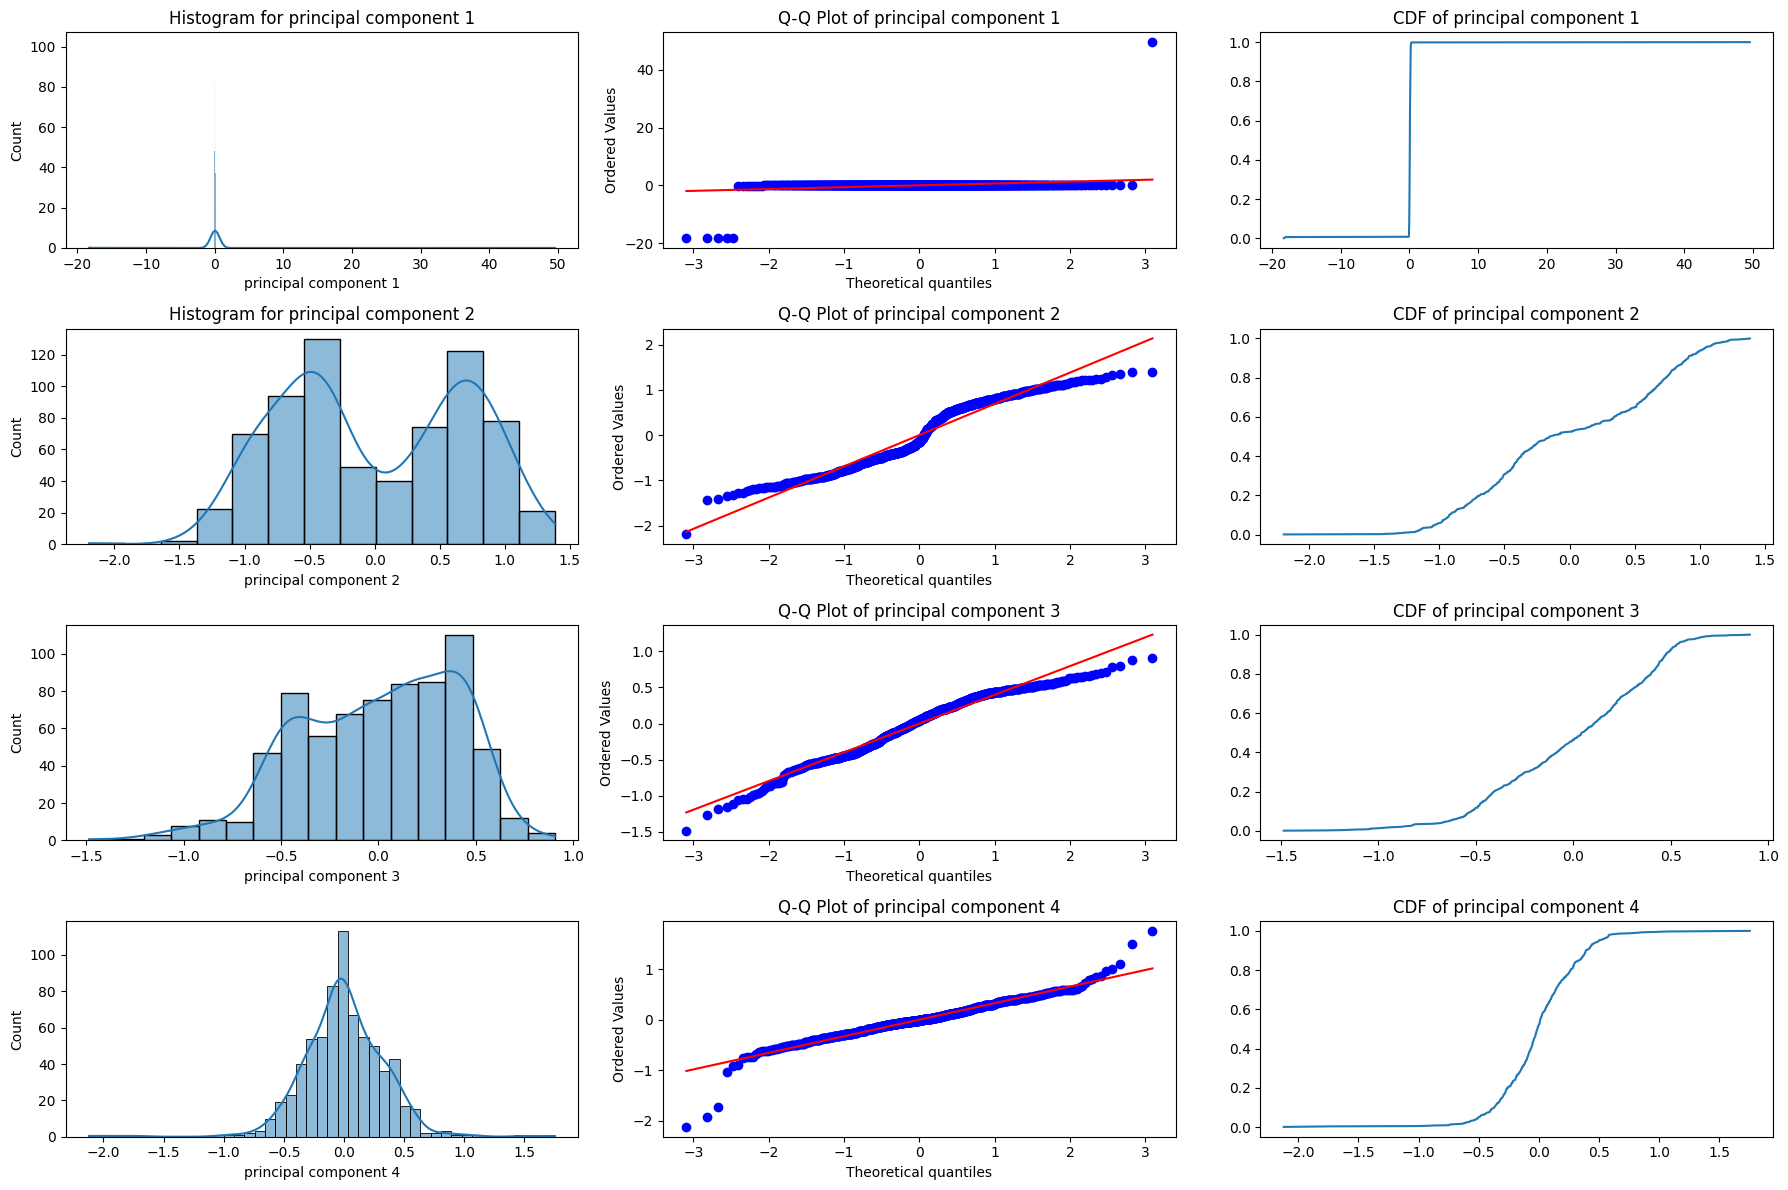

In [228]:
# 결론은 2,3,4를 쓰는게 낫다. 

plt.rcParams['font.family'] = 'DejaVu Sans'
# Q-Q Plot
def qq_plot(data, ax, feature_name):
    probplot(data, dist="norm", plot=ax)
    ax.set_title(f'Q-Q Plot of {feature_name}')

# CDF Plot
def plot_cdf(data, ax, feature_name):
    sorted_data = np.sort(data)
    yvals = np.arange(1, len(sorted_data)+1) / float(len(sorted_data))
    ax.plot(sorted_data, yvals)
    ax.set_title(f'CDF of {feature_name}')

# Visualization
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 12))

# 첫 번째 피처에 대한 히스토그램
sns.histplot(pca_df['principal component 1'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Histogram for principal component 1')

# 첫 번째 피처에 대한 Q-Q Plot
qq_plot(pca_df['principal component 1'], axes[0, 1], 'principal component 1')

# 첫 번째 피처에 대한 CDF Plot
plot_cdf(pca_df['principal component 1'], axes[0, 2], 'principal component 1')

# 두 번째 피처에 대한 히스토그램
sns.histplot(pca_df['principal component 2'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Histogram for principal component 2')

# 두 번째 피처에 대한 Q-Q Plot
qq_plot(pca_df['principal component 2'], axes[1, 1], 'principal component 2')

# 두 번째 피처에 대한 CDF Plot
plot_cdf(pca_df['principal component 2'], axes[1, 2], 'principal component 2')

# 두 번째 피처에 대한 히스토그램
sns.histplot(pca_df['principal component 3'], kde=True, ax=axes[2, 0])
axes[1, 0].set_title('Histogram for principal component 2')

# 두 번째 피처에 대한 Q-Q Plot
qq_plot(pca_df['principal component 3'], axes[2, 1], 'principal component 3')

# 두 번째 피처에 대한 CDF Plot
plot_cdf(pca_df['principal component 3'], axes[2, 2], 'principal component 3')

# 두 번째 피처에 대한 히스토그램
sns.histplot(pca_df['principal component 4'], kde=True, ax=axes[3, 0])
axes[1, 0].set_title('Histogram for principal component 2')

# 두 번째 피처에 대한 Q-Q Plot
qq_plot(pca_df['principal component 4'], axes[3, 1], 'principal component 4')

# 두 번째 피처에 대한 CDF Plot
plot_cdf(pca_df['principal component 4'], axes[3, 2], 'principal component 4')

plt.tight_layout()
plt.show()


In [229]:
# 축소된 데이터에 클래스 추가
pca_df['품질상태'] = all_feature['품질상태']
pca_df

,principal component 1,principal component 2,principal component 3,principal component 4,품질상태
0,-0.033297,0.236676,-0.871714,0.285621,0
1,0.149635,-0.404631,-0.490574,0.442295,0
2,0.091701,-0.748988,-0.326539,0.809533,0
3,0.140064,-0.978657,-0.435566,0.061959,0
4,0.195215,-1.288676,-0.279767,0.148386,0
...,...,...,...,...,...
698,-0.030966,0.882503,0.075248,0.477746,1
699,0.014486,0.715778,0.004486,0.196977,1
700,0.018775,0.595625,0.108132,0.148030,1
701,0.057889,0.670267,0.064449,0.230568,1


In [220]:
pca_df.columns

Index(['principal component 1', 'principal component 2',
       'principal component 3', 'principal component 4', '품질상태'],
      dtype='object')

In [230]:
def separate_features_and_class(df):
    X = df.iloc[:, :-1]  # 모든 열 제외 마지막 열 (피처)
    y = df.iloc[:, -1]   # 마지막 열 (클래스)
    return X, y

pca_X, pca_y = separate_features_and_class(pca_df)

# StandardScaler 객체 생성
scaler = StandardScaler()

# one_feature 데이터 프레임 표준화
pca_scaled = scaler.fit_transform(pca_X)
pca_scaled_df = pd.DataFrame(pca_scaled, columns=pca_X.columns)

# 데이터 섞기 및 훈련/테스트 데이터로 분리
def split_train_test(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

pca_X_train, pca_X_test, pca_y_train, pca_y_test = split_train_test(pca_X, pca_y)

In [179]:
# 인덱스 재설정
one_feature.set_index('파일명', inplace=True)
all_feature.set_index('파일명', inplace=True)

# train, test data 분리
# 데이터 프레임에서 클래스와 피처 분리
def separate_features_and_class(df):
    X = df.iloc[:, :-1]  # 모든 열 제외 마지막 열 (피처)
    y = df.iloc[:, -1]   # 마지막 열 (클래스)
    return X, y

one_X, one_y = separate_features_and_class(one_feature)
all_X, all_y = separate_features_and_class(all_feature)


# StandardScaler 객체 생성
scaler = StandardScaler()

# one_feature 데이터 프레임 표준화
one_scaled = scaler.fit_transform(one_X)
one_scaled_df = pd.DataFrame(one_scaled, columns=one_X.columns)

# all_feature 데이터 프레임 표준화
all_scaled = scaler.fit_transform(all_X)
all_scaled_df = pd.DataFrame(all_scaled, columns=all_X.columns)

# 데이터 섞기 및 훈련/테스트 데이터로 분리
def split_train_test(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

one_X_train, one_X_test, one_y_train, one_y_test = split_train_test(one_X, one_y)
all_X_train, all_X_test, all_y_train, all_y_test = split_train_test(all_X, all_y)

In [131]:
print(one_scaled)

[[ 0.         -0.97157758 -0.49453289 ... -0.05569292  0.8964918
   0.58262922]
 [ 0.          0.29868286  0.2396944  ... -0.45614739  0.0106641
  -0.29466843]
 [ 0.          1.18786517  1.21866412 ... -2.31672045 -0.56294564
   0.2536426 ]
 ...
 [ 0.         -1.22562967 -1.10638897 ... -0.05569292  0.91827445
  -0.29466843]
 [ 0.         -1.09860362 -1.47350261 ... -0.28364393  1.07075299
  -0.56882395]
 [ 0.         -0.97157758 -0.61690411 ... -1.06607035  1.24501418
  -0.13017512]]


# Random Forest 

In [182]:
# A군
# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(one_X_train, one_y_train)

# Predict on the test set
y_pred = rf_classifier.predict(one_X_test)

# Evaluate the model
accuracy = accuracy_score(one_y_test, y_pred)
class_report = classification_report(one_y_test, y_pred)

accuracy
print(class_report)


              precision    recall  f1-score   support

           0       0.89      0.66      0.76        38
           1       0.88      0.97      0.93       103

    accuracy                           0.89       141
   macro avg       0.89      0.81      0.84       141
weighted avg       0.89      0.89      0.88       141



In [183]:
# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(all_X_train, all_y_train)

# Predict on the test set
y_pred = rf_classifier.predict(all_X_test)

# Evaluate the model
accuracy = accuracy_score(all_y_test, y_pred)
class_report = classification_report(all_y_test, y_pred)

accuracy
print(class_report)


              precision    recall  f1-score   support

           0       0.93      0.66      0.77        38
           1       0.89      0.98      0.93       103

    accuracy                           0.89       141
   macro avg       0.91      0.82      0.85       141
weighted avg       0.90      0.89      0.89       141



In [217]:
print(pca_X_train.shape)
print(pca_X_test.shape)
print(pca_y_train.shape)
print(pca_y_test.shape)

(562, 4)
(141, 4)
(562,)
(141,)


In [215]:
# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(pca_X_train, pca_y_train)

# Predict on the test set
y_pred = rf_classifier.predict(pca_X_test)

# Evaluate the model
accuracy = accuracy_score(pca_y_test, y_pred)
class_report = classification_report(pca_y_test, y_pred)

accuracy
print(class_report)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00       103

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141



# 2. Logistic Regression

In [184]:
# 로지스틱 회귀 모델 생성 및 훈련
logistic_model = LogisticRegression()
logistic_model.fit(one_X_train, one_y_train)

# 테스트 세트에서 예측
y_pred = logistic_model.predict(one_X_test)

# 모델 평가
accuracy = accuracy_score(one_y_test, y_pred)
report = classification_report(one_y_test, y_pred)

print("Accuracy: ", accuracy, "\n")
print(report)

Accuracy:  0.8439716312056738 

              precision    recall  f1-score   support

           0       0.86      0.50      0.63        38
           1       0.84      0.97      0.90       103

    accuracy                           0.84       141
   macro avg       0.85      0.74      0.77       141
weighted avg       0.85      0.84      0.83       141



In [189]:
# 로지스틱 회귀 모델 생성 및 훈련
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(all_X_train, all_y_train)

# 테스트 세트에서 예측
y_pred = logistic_model.predict(all_X_test)

# 모델 평가
accuracy = accuracy_score(all_y_test, y_pred)
report = classification_report(all_y_test, y_pred)

print("Accuracy: ", accuracy, "\n")
print(report)

Accuracy:  0.8368794326241135 

              precision    recall  f1-score   support

           0       0.80      0.53      0.63        38
           1       0.84      0.95      0.89       103

    accuracy                           0.84       141
   macro avg       0.82      0.74      0.76       141
weighted avg       0.83      0.84      0.82       141



In [218]:
# pca
pca_X_train, pca_X_test, pca_y_train, pca_y_test

# 로지스틱 회귀 모델 생성 및 훈련
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(pca_X_train, pca_y_train)

# 테스트 세트에서 예측
y_pred = logistic_model.predict(pca_X_test)

# 모델 평가
accuracy = accuracy_score(pca_y_test, y_pred)
report = classification_report(pca_y_test, y_pred)

print("Accuracy: ", accuracy, "\n")
print(report)

Accuracy:  1.0 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00       103

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141



# 3. KNN

Best k: 4


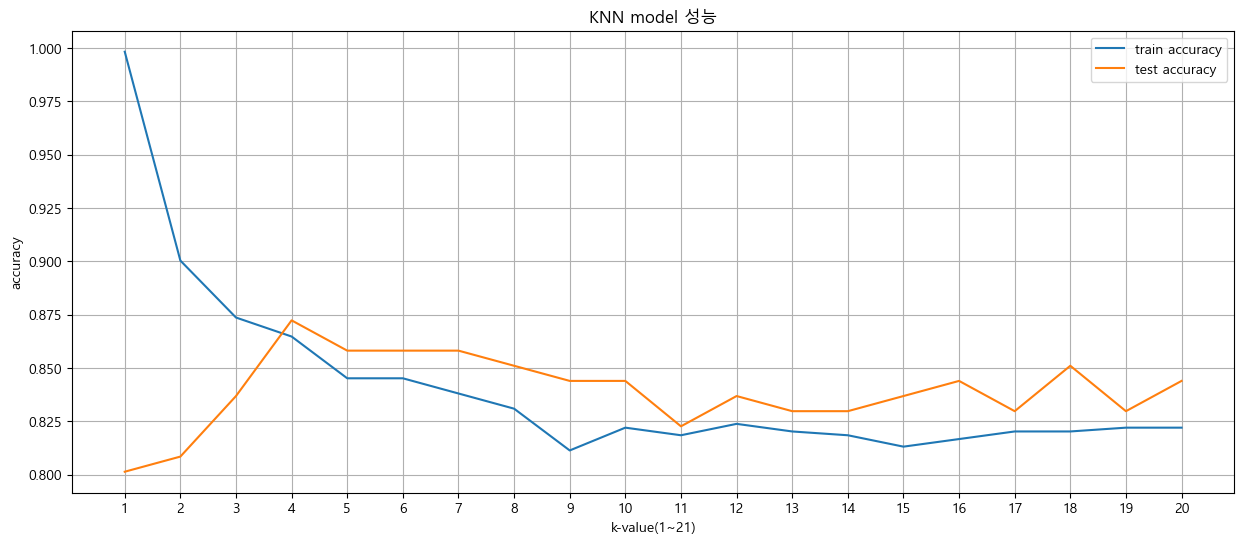

In [191]:
# KNN 모델 생성 및 훈련
k_values = range(1, 21)
train_scores = []
test_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(one_X_train, one_y_train)

    train_pred = knn.predict(one_X_train)
    train_accuracy = accuracy_score(one_y_train, train_pred)
    train_scores.append(train_accuracy)

    test_pred = knn.predict(one_X_test)
    test_accuracy = accuracy_score(one_y_test, test_pred)
    test_scores.append(test_accuracy)

# 테스트 정확도 기반 최적의 k 값 선택
best_k = k_values[np.argmax(test_scores)]
print(f"Best k: {best_k}")

# 진행 상황 시각화
plt.figure(figsize=(15, 6))
plt.plot(k_values, train_scores, label='train accuracy')
plt.plot(k_values, test_scores, label='test accuracy')
plt.xlabel('k-value(1~21)')
plt.ylabel('accuracy')
plt.title('KNN model 성능')
plt.legend()
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [192]:
# 최적의 k 값으로 최종 KNN 모델 훈련
final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(one_X_train, one_y_train)

# 테스트 세트에서 예측
y_pred = final_knn.predict(one_X_test)

# 모델 평가
accuracy = accuracy_score(one_y_test, y_pred)
print(f"정확도: {accuracy:.2f}")
print("\n")
print("분류 보고서:")
print(classification_report(one_y_test, y_pred))

정확도: 0.87


분류 보고서:
              precision    recall  f1-score   support

           0       0.83      0.66      0.74        38
           1       0.88      0.95      0.92       103

    accuracy                           0.87       141
   macro avg       0.86      0.80      0.83       141
weighted avg       0.87      0.87      0.87       141



Best k: 6


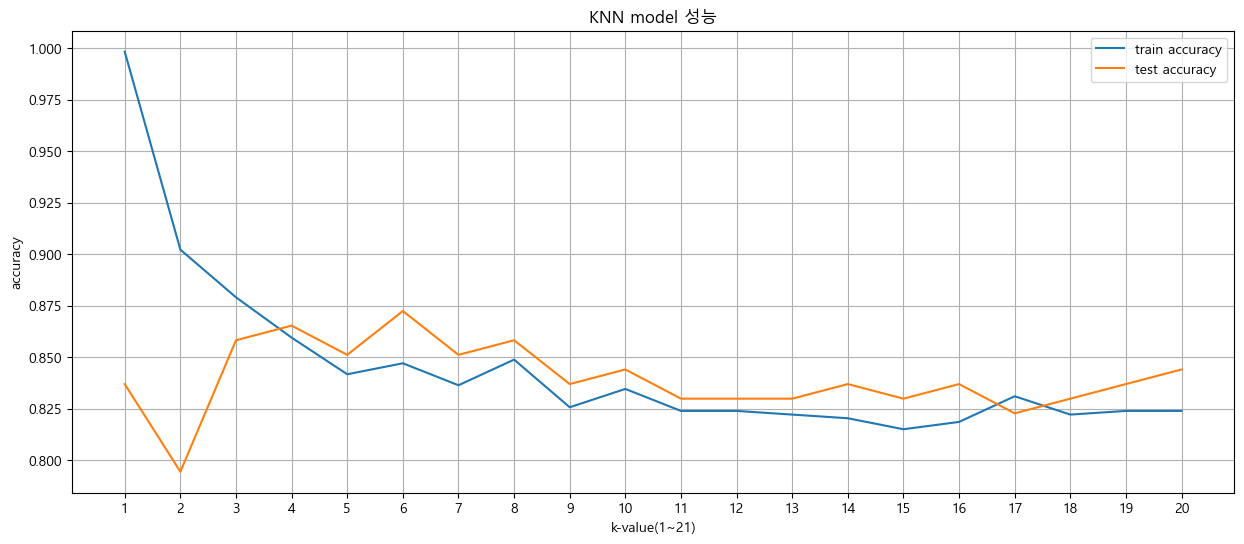

In [194]:
# KNN 모델 생성 및 훈련 (B군)
k_values = range(1, 21)
train_scores = []
test_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(all_X_train, all_y_train)

    train_pred = knn.predict(all_X_train)
    train_accuracy = accuracy_score(all_y_train, train_pred)
    train_scores.append(train_accuracy)

    test_pred = knn.predict(all_X_test)
    test_accuracy = accuracy_score(all_y_test, test_pred)
    test_scores.append(test_accuracy)

# 테스트 정확도 기반 최적의 k 값 선택
best_k = k_values[np.argmax(test_scores)]
print(f"Best k: {best_k}")

# 진행 상황 시각화
plt.figure(figsize=(15, 6))
plt.plot(k_values, train_scores, label='train accuracy')
plt.plot(k_values, test_scores, label='test accuracy')
plt.xlabel('k-value(1~21)')
plt.ylabel('accuracy')
plt.title('KNN model 성능')
plt.legend()
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [195]:
# 최적의 k 값으로 최종 KNN 모델 훈련
final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(all_X_train, all_y_train)

# 테스트 세트에서 예측
y_pred = final_knn.predict(all_X_test)

# 모델 평가
accuracy = accuracy_score(all_y_test, y_pred)
print(f"정확도: {accuracy:.2f}")
print("\n")
print("분류 보고서:")
print(classification_report(all_y_test, y_pred))

정확도: 0.87


분류 보고서:
              precision    recall  f1-score   support

           0       0.86      0.63      0.73        38
           1       0.88      0.96      0.92       103

    accuracy                           0.87       141
   macro avg       0.87      0.80      0.82       141
weighted avg       0.87      0.87      0.87       141



Best k: 1


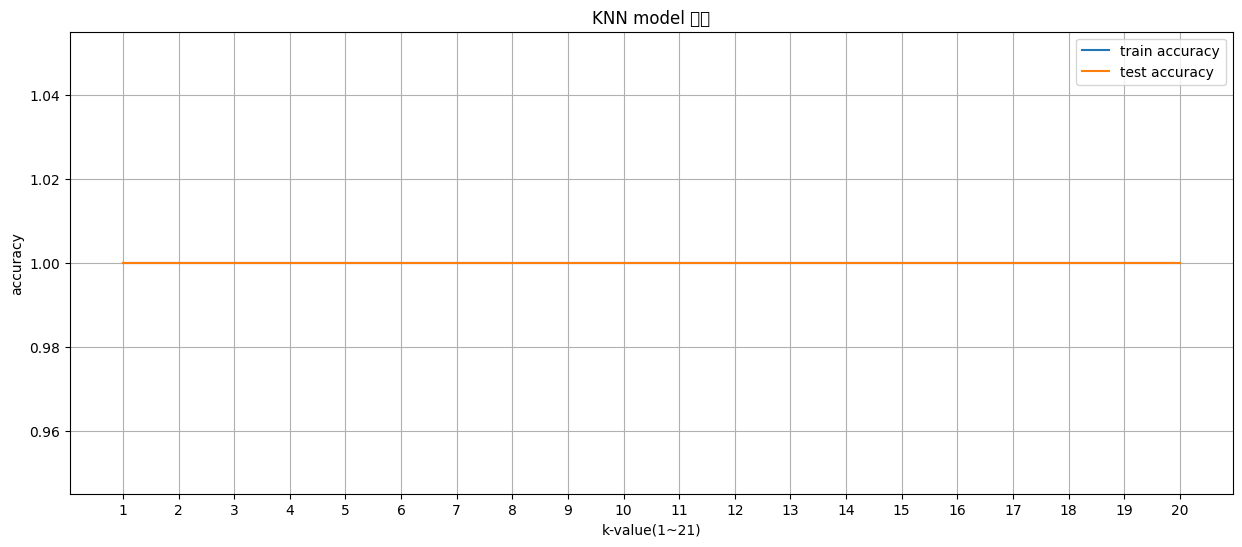

In [233]:
# KNN 모델 생성 및 훈련 (B군)
k_values = range(1, 21)
train_scores = []
test_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(pca_X_train, pca_y_train)

    train_pred = knn.predict(pca_X_train)
    train_accuracy = accuracy_score(pca_y_train, train_pred)
    train_scores.append(train_accuracy)

    test_pred = knn.predict(pca_X_test)
    test_accuracy = accuracy_score(pca_y_test, test_pred)
    test_scores.append(test_accuracy)

# 테스트 정확도 기반 최적의 k 값 선택
best_k = k_values[np.argmax(test_scores)]
print(f"Best k: {best_k}")

# 진행 상황 시각화
plt.figure(figsize=(15, 6))
plt.plot(k_values, train_scores, label='train accuracy')
plt.plot(k_values, test_scores, label='test accuracy')
plt.xlabel('k-value(1~21)')
plt.ylabel('accuracy')
plt.title('KNN model 성능')
plt.legend()
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [234]:
# 최적의 k 값으로 최종 KNN 모델 훈련
final_knn = KNeighborsClassifier(n_neighbors=best_k)
final_knn.fit(pca_X_train, pca_y_train)

# 테스트 세트에서 예측
y_pred = final_knn.predict(pca_X_test)

# 모델 평가
accuracy = accuracy_score(pca_y_test, y_pred)
print(f"정확도: {accuracy:.2f}")
print("\n")
print("분류 보고서:")
print(classification_report(pca_y_test, y_pred))

정확도: 1.00


분류 보고서:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00       103

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141



# 4. SVM

In [198]:
# SVM 모델 생성 및 훈련
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(one_X_train, one_y_train)

# 테스트 세트에서 예측
svm_y_pred = svm_model.predict(one_X_test)

# 모델 평가
svm_accuracy = accuracy_score(one_y_test, svm_y_pred)
svm_report = classification_report(one_y_test, svm_y_pred)

print("SVM Accuracy: ", svm_accuracy, "\n")
print(svm_report)

SVM Accuracy:  0.8581560283687943 

              precision    recall  f1-score   support

           0       0.95      0.50      0.66        38
           1       0.84      0.99      0.91       103

    accuracy                           0.86       141
   macro avg       0.90      0.75      0.78       141
weighted avg       0.87      0.86      0.84       141



In [197]:
# SVM 모델 생성 및 훈련
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(all_X_train, all_y_train)

# 테스트 세트에서 예측
svm_y_pred = svm_model.predict(all_X_test)

# 모델 평가
svm_accuracy = accuracy_score(all_y_test, svm_y_pred)
svm_report = classification_report(all_y_test, svm_y_pred)

print("SVM Accuracy: ", svm_accuracy, "\n")
print(svm_report)

SVM Accuracy:  0.8794326241134752 

              precision    recall  f1-score   support

           0       0.96      0.58      0.72        38
           1       0.86      0.99      0.92       103

    accuracy                           0.88       141
   macro avg       0.91      0.78      0.82       141
weighted avg       0.89      0.88      0.87       141



In [235]:
# SVM 모델 생성 및 훈련
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(pca_X_train, pca_y_train)

# 테스트 세트에서 예측
svm_y_pred = svm_model.predict(pca_X_test)

# 모델 평가
svm_accuracy = accuracy_score(pca_y_test, svm_y_pred)
svm_report = classification_report(pca_y_test, svm_y_pred)

print("SVM Accuracy: ", svm_accuracy, "\n")
print(svm_report)

SVM Accuracy:  1.0 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00       103

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141



# 5. Gradient Descent

In [201]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(one_X_train, one_y_train)

y_pred = gb_clf.predict(one_X_test)
y_pred_prob = gb_clf.predict_proba(one_X_test)[:, 1]

accuracy = accuracy_score(one_y_test, y_pred)
conf_matrix = confusion_matrix(one_y_test, y_pred)
class_report = classification_report(one_y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(class_report)

Accuracy: 0.8936170212765957
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.71      0.78        38
           1       0.90      0.96      0.93       103

    accuracy                           0.89       141
   macro avg       0.89      0.84      0.86       141
weighted avg       0.89      0.89      0.89       141



In [200]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(all_X_train, all_y_train)

y_pred = gb_clf.predict(all_X_test)
y_pred_prob = gb_clf.predict_proba(all_X_test)[:, 1]

accuracy = accuracy_score(all_y_test, y_pred)
conf_matrix = confusion_matrix(all_y_test, y_pred)
class_report = classification_report(all_y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(class_report)

Accuracy: 0.8794326241134752
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.68      0.75        38
           1       0.89      0.95      0.92       103

    accuracy                           0.88       141
   macro avg       0.86      0.82      0.84       141
weighted avg       0.88      0.88      0.88       141



In [237]:
pca_X_train, pca_X_test, pca_y_train, pca_y_test 

gb_clf = GradientBoostingClassifier()
gb_clf.fit(pca_X_train, pca_y_train)

y_pred = gb_clf.predict(pca_X_test)
y_pred_prob = gb_clf.predict_proba(pca_X_test)[:, 1]

accuracy = accuracy_score(pca_y_test, y_pred)
conf_matrix = confusion_matrix(pca_y_test, y_pred)
class_report = classification_report(pca_y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(class_report)

Accuracy: 0.9929078014184397
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.99      1.00      1.00       103

    accuracy                           0.99       141
   macro avg       1.00      0.99      0.99       141
weighted avg       0.99      0.99      0.99       141



# 6. XGBoost

In [208]:
# Ensure column names are strings without problematic characters
one_X_train.columns = [str(col).replace('[','').replace(']','').replace('<','') for col in one_X_train.columns]
one_X_test.columns = [str(col).replace('[','').replace(']','').replace('<','') for col in one_X_test.columns]

# Step 2: Train the XGBoost Classifier
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(one_X_train, one_y_train)

# Step 3: Making predictions on the test set
y_pred = xgb_clf.predict(one_X_test)

# Step 4: Evaluating the model
accuracy = accuracy_score(one_y_test, y_pred)
conf_matrix = confusion_matrix(one_y_test, y_pred)
class_report = classification_report(one_y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.900709219858156
Confusion Matrix:
[[ 26  12]
 [  2 101]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.68      0.79        38
           1       0.89      0.98      0.94       103

    accuracy                           0.90       141
   macro avg       0.91      0.83      0.86       141
weighted avg       0.90      0.90      0.90       141



In [207]:
# Ensure column names are strings without problematic characters
all_X_train.columns = [str(col).replace('[','').replace(']','').replace('<','') for col in all_X_train.columns]
all_X_test.columns = [str(col).replace('[','').replace(']','').replace('<','') for col in all_X_test.columns]

# Step 2: Train the XGBoost Classifier
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(all_X_train, all_y_train)

# Step 3: Making predictions on the test set
y_pred = xgb_clf.predict(all_X_test)

# Step 4: Evaluating the model
accuracy = accuracy_score(all_y_test, y_pred)
conf_matrix = confusion_matrix(all_y_test, y_pred)
class_report = classification_report(all_y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.900709219858156
Confusion Matrix:
[[ 27  11]
 [  3 100]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.71      0.79        38
           1       0.90      0.97      0.93       103

    accuracy                           0.90       141
   macro avg       0.90      0.84      0.86       141
weighted avg       0.90      0.90      0.90       141



In [239]:
pca_X_train.columns 

Index(['principal component 1', 'principal component 2',
       'principal component 3', 'principal component 4'],
      dtype='object')

In [240]:
# Ensure column names are strings without problematic characters
pca_X_train.columns = [str(col).replace('[','').replace(']','').replace('<','') for col in pca_X_train.columns]
pca_X_test.columns = [str(col).replace('[','').replace(']','').replace('<','') for col in pca_X_test.columns]

# Step 2: Train the XGBoost Classifier
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(pca_X_train, pca_y_train)

# Step 3: Making predictions on the test set
y_pred = xgb_clf.predict(pca_X_test)

# Step 4: Evaluating the model
accuracy = accuracy_score(pca_y_test, y_pred)
conf_matrix = confusion_matrix(pca_y_test, y_pred)
class_report = classification_report(pca_y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 1.0
Confusion Matrix:
[[ 38   0]
 [  0 103]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00       103

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141



# MLP

In [212]:
# MLP 모델 생성 및 훈련
mlp_model = MLPClassifier(hidden_layer_sizes=(100,50), activation='relu', solver='adam', max_iter=50, random_state=42)
mlp_model.fit(one_X_train, one_y_train)

# 테스트 세트에서 예측
mlp_y_pred = mlp_model.predict(one_X_test)

# 모델 평가
mlp_accuracy = accuracy_score(one_y_test, mlp_y_pred)
mlp_report = classification_report(one_y_test, mlp_y_pred)
print("MLP Accuracy: ", mlp_accuracy, "\n")
print(mlp_report)

MLP Accuracy:  0.8652482269503546 

              precision    recall  f1-score   support

           0       0.91      0.55      0.69        38
           1       0.86      0.98      0.91       103

    accuracy                           0.87       141
   macro avg       0.88      0.77      0.80       141
weighted avg       0.87      0.87      0.85       141



c:\Program Files\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [211]:
# MLP 모델 생성 및 훈련
mlp_model = MLPClassifier(hidden_layer_sizes=(100,50), activation='relu', solver='adam', max_iter=50, random_state=42)
mlp_model.fit(all_X_train, all_y_train)

# 테스트 세트에서 예측
mlp_y_pred = mlp_model.predict(all_X_test)

# 모델 평가
mlp_accuracy = accuracy_score(all_y_test, mlp_y_pred)
mlp_report = classification_report(all_y_test, mlp_y_pred)
print("MLP Accuracy: ", mlp_accuracy, "\n")
print(mlp_report)

MLP Accuracy:  0.7375886524822695 

              precision    recall  f1-score   support

           0       1.00      0.03      0.05        38
           1       0.74      1.00      0.85       103

    accuracy                           0.74       141
   macro avg       0.87      0.51      0.45       141
weighted avg       0.81      0.74      0.63       141



c:\Program Files\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


In [241]:
pca_X_train, pca_X_test, pca_y_train, pca_y_test 

# MLP 모델 생성 및 훈련
mlp_model = MLPClassifier(hidden_layer_sizes=(100,50), activation='relu', solver='adam', max_iter=50, random_state=42)
mlp_model.fit(pca_X_train, pca_y_train)

# 테스트 세트에서 예측
mlp_y_pred = mlp_model.predict(pca_X_test)

# 모델 평가
mlp_accuracy = accuracy_score(pca_y_test, mlp_y_pred)
mlp_report = classification_report(pca_y_test, mlp_y_pred)
print("MLP Accuracy: ", mlp_accuracy, "\n")
print(mlp_report)

MLP Accuracy:  1.0 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        38
           1       1.00      1.00      1.00       103

    accuracy                           1.00       141
   macro avg       1.00      1.00      1.00       141
weighted avg       1.00      1.00      1.00       141



c:\Program Files\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
